## **Identificación De Especies de Mosquitos - Data Science**

Carol Arévalo, Stefano Aragoni, Luis Santos, Diego Perdomo

### *Modelo*

El Ministerio de Salud y Asistencia Social (MSPAS) ha informado que Guatemala ha experimentado un aumento significativo en el número de casos de dengue en 2023, con más de 10,000 casos confirmados y 21 muertes hasta el 12 de agosto. El MSPAS ha declarado una alerta epidemiológica en todo el país para combatir la propagación del dengue (Gobierno De Guatemala, 2023).  


Con esto en mente, el presente proyecto busca utilizar técnicas de procesamiento de imágenes y aprendizaje automático para identificar la especie de mosquito Aedes aegypti a partir de imágenes, con el fin de apoyar los esfuerzos de prevención del dengue en Guatemala.

#### Librerías

Como primer paso, se importan las librerías necesarias para el desarrollo del proyecto.

In [132]:
import os
import tensorflow as tf
import logging
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Conv2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
tf.get_logger().setLevel(logging.ERROR)

#### Cargas las imagenes

In [133]:
data = pd.read_csv('phase2_train_v0.csv')

#### Preprocesamiento

##### Analizar la Distribución de Clases


In [134]:
# Ver la distribución de las clases
class_distribution = data['class_label'].value_counts()
print(class_distribution)

albopictus            4612
culex                 4563
culiseta               622
japonicus/koreicus     429
anopheles               84
aegypti                 47
Name: class_label, dtype: int64


#### Estandarización de Imágenes

In [135]:

input_folder = 'final'
output_folder = 'procesadas'

# 1. Crea la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

    # 2. Recorte, redimensionado y normalización
    target_width = 100
    target_height = 100

    for index in tqdm(range(len(data))):
        row = data.iloc[index]
        filename = row.img_fName
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)
        img = img.crop((row.bbx_xtl, row.bbx_ytl, row.bbx_xbr, row.bbx_ybr))
        img = img.resize((target_width, target_height), Image.LANCZOS)
        
        # Convertir la imagen a escala de grises
        img = img.convert("L")
        
        img = np.array(img) / 255.0
        output_path = os.path.join(output_folder, filename)
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(output_path)

else:
    print("Las imágenes ya están procesadas")

Las imágenes ya están procesadas


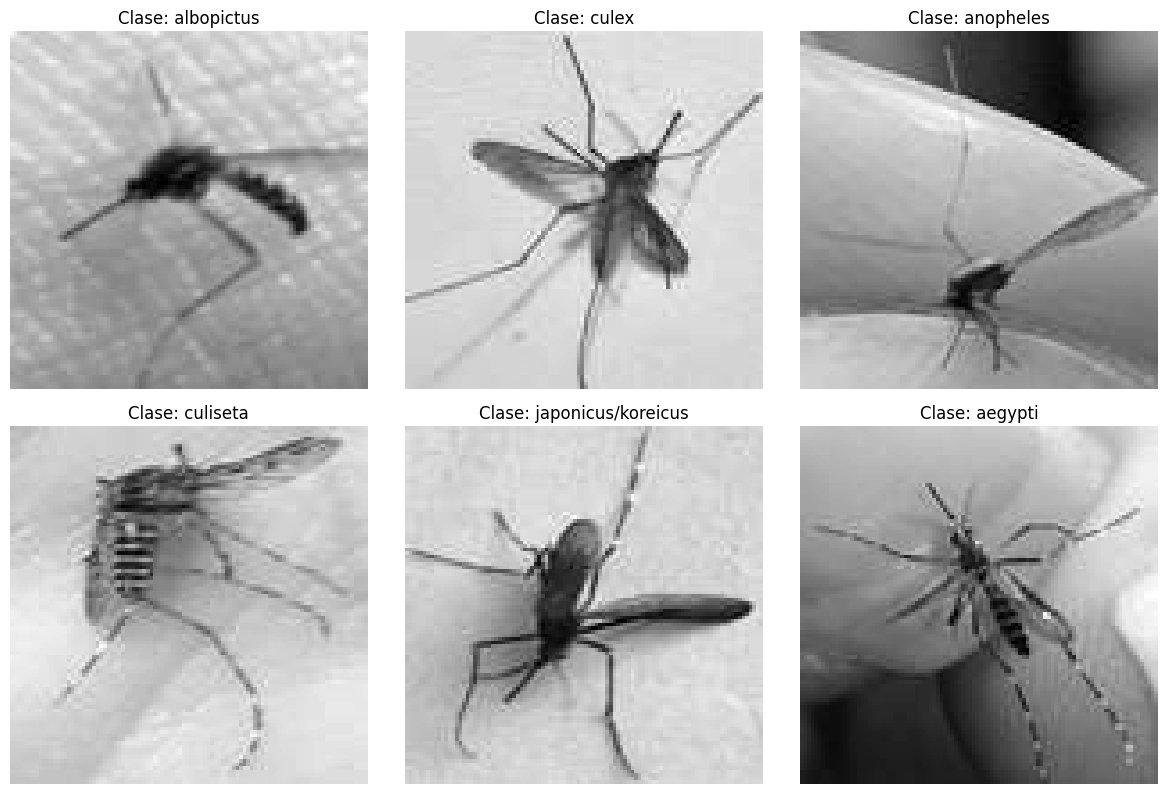

In [136]:
# 3. Visualización de las clases únicas
unique_classes = data['class_label'].unique()
num_rows = len(unique_classes) // 3 + 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, class_label in enumerate(unique_classes):
    class_data = data[data['class_label'] == class_label]
    first_image_name = class_data.iloc[0]['img_fName']
    image_path = os.path.join(output_folder, first_image_name)
    img = Image.open(image_path)
    
    row = i // num_cols
    col = i % num_cols
    
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'Clase: {class_label}')
    axes[row, col].axis('off')

for i in range(len(unique_classes), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [137]:
# 4. Generación de imágenes adicionales
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

max_images = data['class_label'].value_counts().max()
data_balanced = pd.DataFrame(columns=['img_fName', 'class_label'])
data_balanced = pd.concat([data_balanced, data], ignore_index=True)
unique = data['class_label'].unique()

for class_label in tqdm(unique):
    class_count = sum(data['class_label'] == class_label)
    
    if class_count < max_images:
        num_new_images = max_images - class_count
        class_images = data[data['class_label'] == class_label]['img_fName']
        
        for i, original_image_name in enumerate(class_images):
            img = load_img(os.path.join(output_folder, original_image_name), color_mode='grayscale')
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                i += 1
                if i > num_new_images:
                    break
                
                new_img = array_to_img(batch[0], scale=False)
                new_image_name = f'new_image_{original_image_name.split(".")[0]}_{i}.jpeg'
                new_img.save(os.path.join(output_folder, new_image_name))
                
                new_data = pd.DataFrame({
                    'img_fName': [new_image_name],
                    'class_label': [class_label]
                })
                data_balanced = pd.concat([data_balanced, new_data], ignore_index=True)
                
            if i >= num_new_images:
                break

100%|██████████| 6/6 [00:19<00:00,  3.23s/it]


In [138]:
data_balanced = shuffle(data_balanced)
print(data_balanced['class_label'].value_counts())

data_balanced.to_csv('data_balanced.csv', index=False)

albopictus            4612
aegypti               4612
culiseta              4612
anopheles             4612
japonicus/koreicus    4612
culex                 4612
Name: class_label, dtype: int64


In [139]:
# Tamaño deseado de las imágenes
img_width, img_height = 150, 150

# 1. Hacer Resize de imágenes:
# Ya está realizado en el 'target_size' del generador de datos.

# 2. Hacer Data Augmentation:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# 3. Usar Batches:
# Se están usando batches en el código con 'batch_size=32' en los generadores.

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_balanced,
    directory='procesadas',
    x_col='img_fName',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_balanced,
    directory='procesadas',
    x_col='img_fName',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 22138 validated image filenames belonging to 6 classes.
Found 5534 validated image filenames belonging to 6 classes.


In [140]:
# export train_generator.class_indices
with open('class_indices.json', 'w') as fp:
    json.dump(train_generator.class_indices, fp)

#### Definición del Modelo

In [141]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))  # Incrementa el Dropout

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))  # Incrementa el Dropout

model.add(Dense(6, activation='softmax'))

##### Compilación del modelo

In [142]:
# Compilación del modelo
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#### Entrenamiento

In [143]:
# Entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath="best_model.h5", verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[early_stop, checkpointer]
)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 34.4163 - accuracy: 0.5655
Epoch 1: val_loss improved from inf to 34.67855, saving model to best_model.h5
200/200 [==============================] - 83s 393ms/step - loss: 34.4163 - accuracy: 0.5655 - val_loss: 34.6786 - val_accuracy: 0.3125


/Users/ls/miniconda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 31.2848 - accuracy: 0.6438
Epoch 2: val_loss improved from 34.67855 to 29.75892, saving model to best_model.h5
200/200 [==============================] - 78s 389ms/step - loss: 31.2848 - accuracy: 0.6438 - val_loss: 29.7589 - val_accuracy: 0.6300
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 29.7614 - accuracy: 0.6564
Epoch 3: val_loss improved from 29.75892 to 25.95459, saving model to best_model.h5
200/200 [==============================] - 80s 398ms/step - loss: 29.7614 - accuracy: 0.6564 - val_loss: 25.9546 - val_accuracy: 0.7437
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 28.2792 - accuracy: 0.6742
Epoch 4: val_loss did not improve from 25.95459
200/200 [==============================] - 77s 387ms/step - loss: 28.2792 - accuracy: 0.6742 - val_loss: 26.3613 - val_accuracy: 0.7869
Epoch 5/20
200/200 [==============================] - ETA: 0s - loss: 29.0107 - accur

KeyboardInterrupt: 

#### Resultados del Modelo

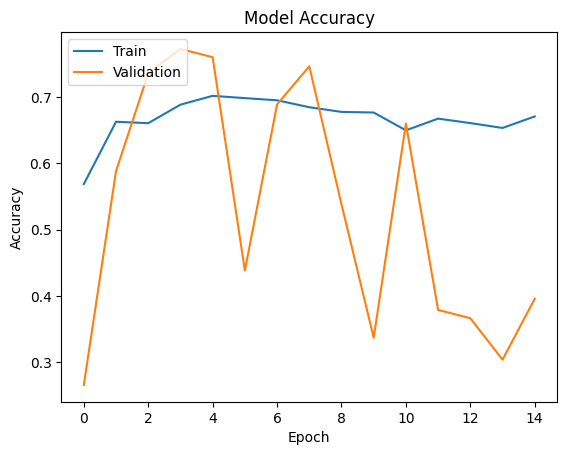

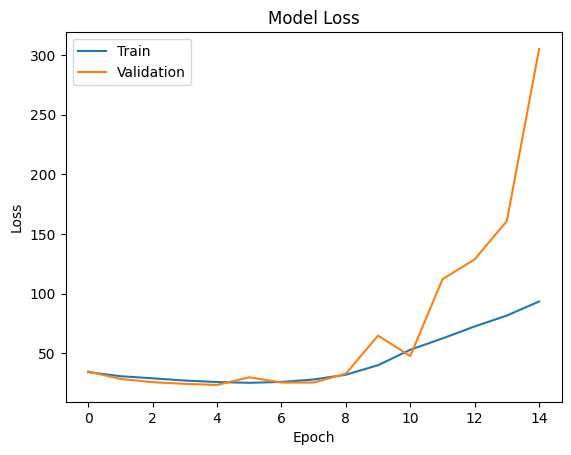

In [ ]:
# Gráfica

# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Validacion con imagen 

In [ ]:
def predict_mosquito_type(model, img_path):
    """
    Predicts the type of mosquito based on an image.

    Parameters:
        model : tensorflow.keras.Model
            The trained model to use for prediction.
        img_path : str
            Path to the image file to predict.
    """
    # Load and resize the image
    img = image.load_img(img_path, target_size=(150, 150))

    # Display the image
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Convert the image to a numpy array and scale the pixel values to [0, 1]
    img_array = image.img_to_array(img) / 255.

    # Expand dimensions to represent a batch size of 1
    img_batch = np.expand_dims(img_array, axis=0)

    # Get the model's prediction
    prediction = model.predict(img_batch)

    # Get the index of the highest predicted value
    predicted_index = np.argmax(prediction)

    # Retrieve the class labels from the training data generator
    labels = (train_generator.class_indices)
    labels = dict((v, k) for k, v in labels.items())  # flip the key, values in the dictionary

    # Get the string label for the prediction
    predicted_label = labels[predicted_index]

    # Display the prediction
    print(f"Prediction: {predicted_label} ({100*np.max(prediction):.2f}%)")

    return predicted_label

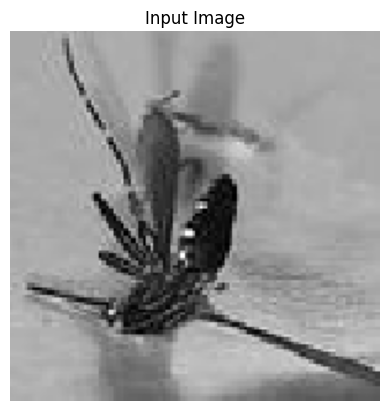

1/1 [==============================] - 0s 419ms/step
Prediction: anopheles (100.00%)


'anopheles'

In [ ]:
predict_mosquito_type(model, "prueba.jpeg")